In [65]:
!pip install ipywidgets

import nest
import torch
import matplotlib.pyplot as plt

from torchbeast import utils
from torchbeast.core import models

In [72]:
# path to flags.savedir/flags.xpid/model.tar
checkpointpath = "~/logs/torchbeast/torchbeast-20200818-180423/model.tar"
checkpointpath="./gp4/model.tar"

checkpoint_states = torch.load(checkpointpath)

flags = checkpoint_states["flags"]

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
flags = dotdict(flags)

checkpoint_states = torch.load(checkpointpath, map_location=flags.learner_device)
flags = dotdict(flags)

In [73]:
dataset_uses_color = flags.dataset not in ["mnist", "omniglot"]
grayscale = dataset_uses_color and not flags.use_color

env_uses_color = flags.use_color or flags.env_type == "fluid"
if env_uses_color is False:
    grayscale = True
else:
    grayscale = is_color and not dataset_uses_color

if flags.condition:
    dataset = utils.create_dataset(flags.dataset, grayscale)
else:
    dataset = None
    
env_name, config = utils.parse_flags(flags)
env = utils.create_env(env_name, config, grayscale=True, dataset=dataset)

In [75]:
grid_width = 32

obs_shape = env.observation_space["canvas"].shape
action_shape = env.action_space.nvec
order = env.order

model = models.Net(
    obs_shape=obs_shape,
    order=order,
    action_shape=action_shape,
    grid_shape=(grid_width, grid_width),

).eval()

model = model.to(device=flags.learner_device)
model.load_state_dict(checkpoint_states["model_state_dict"])

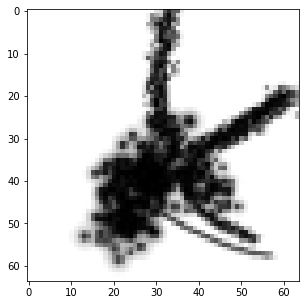

In [76]:
obs = env.reset()
for k in obs.keys():
    obs[k] = torch.from_numpy(obs[k]).unsqueeze(0).unsqueeze(0)
done = torch.tensor([[False]])
core_state = model.initial_state()

for i in range(flags.episode_length):
    (action, logits, baseline), core_state = model(obs, done, core_state)
    action = torch.flatten(action, 0, 1).int().numpy()
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    done = torch.tensor([[done]])
    for k in obs.keys():
        obs[k] = torch.from_numpy(obs[k]).unsqueeze(0).unsqueeze(0)
        # prev_action's original shape has batch dimension
        if k == "prev_action":
            obs[k] = obs[k].view(1, 1, -1)

img = obs["canvas"].view(obs_shape).permute(1, 2, 0).numpy()
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray', interpolation="nearest")